The SIR model for disease

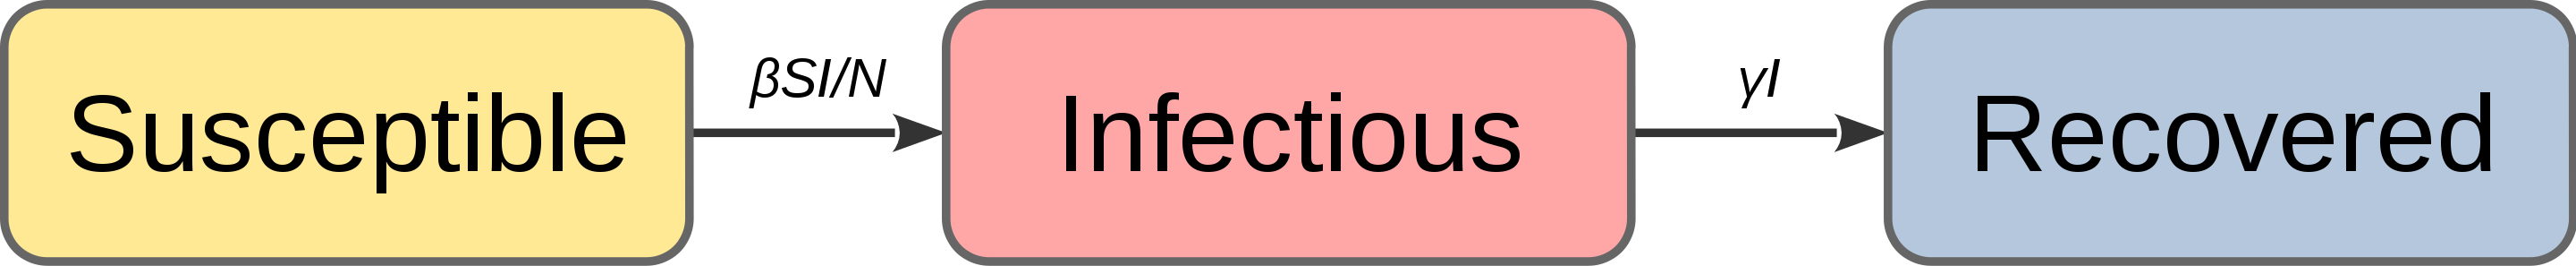

$$\begin{align}
\frac{\partial S}{\partial t} &= D_s \nabla^2 S -\beta \frac{S I}{N} \hspace{20mm}
\frac{\partial I}{\partial t} &= D_i \nabla^2 I + \beta \frac{S I}{N} - \gamma I \hspace{20mm}
\frac{\partial R}{\partial t} &= \gamma I.
\end{align}$$

Source: https://github.com/lukepolson/youtube_channel/blob/main/Python%20Metaphysics%20Series/vid2.ipynb

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

Let $A = (S, I, R)$. Need to define function that takes in $A$ and $t$ and returns $dA/dt = (dS/dt, dI/dt, dR/dt)$

**Parameters and Variables**

- $S$ : Susceptible individuals density (individuals/cm²)
- $I$ : Infectious individuals density (individuals/cm²)
- $R$ : Recovered individuals density (individuals/cm²)
- $\beta$ : Transmission rate (day⁻¹)
- $\gamma$ : Recovery rate (day⁻¹)
- $N$ : Total population
- $D_s$ : Diffusion coefficient for $S$ (cm²/day)
- $D_i$ : Diffusion coefficient for $I$ (cm²/day)

**The Laplace Operator ∇²**

The **Laplace operator** describes spatial diffusion and is defined as the sum of all second spatial derivatives:

$$\nabla^2 u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} + \frac{\partial^2 u}{\partial z^2}$$

**Numerical Approximation (Finite Differences)**

For 1D discretization, we approximate the second derivative:

$$\frac{\partial^2 u}{\partial x^2} \approx \frac{u(x+\Delta x) - 2u(x) + u(x-\Delta x)}{(\Delta x)^2}$$

Enhancing this towards a 2D approximation we end up with a 5-point stencil:
$$
\Delta^2u_{i,j} \approx \frac{u_{i+1,j}-2u_{i,j}+u_{i-1,j}}{\Delta x^2}+\frac{u_{i,j+1}-2u_{i,j}+u_{i,j-1}}{\Delta y^2}
$$

**Typical Parameter Values**

- $D_s = 0.01 - 0.1$ cm²/day
- $D_i = 0.01 - 0.1$ cm²/day
- $\beta = 0.1 - 0.5$ day⁻¹
- $\gamma = 0.05 - 0.2$ day⁻¹
- $N = 1000 - 50000$ (total population)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [22]:
# Reaction parameters
beta = 0.25      # transmission rate
gamma = 0.1     # recovery rate

# Diffusion parameters (corrected model: S and I diffuse)
Ds = 0.10       # diffusion coefficient for S
Di = 0.05       # diffusion coefficient for I

# Domain / grid
Lx, Ly = 10.0, 10.0
nx, ny = 101, 101
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)

# Time
tmax = 365.0

# Stability-guided dt for explicit diffusion in 2D (conservative choice)
Dmax = max(Ds, Di)
dt_max = 1.0 / (2.0 * Dmax * (1.0/dx**2 + 1.0/dy**2))
dt = 0.5 * dt_max  # safety factor
nt = int(np.ceil(tmax / dt))

(beta, gamma, Ds, Di, dx, dy, dt, nt)


(0.25, 0.1, 0.1, 0.05, 0.1, 0.1, 0.0125, 29200)

In [23]:
def apply_neumann_bc(u: np.ndarray) -> None:
    """In-place zero-flux (Neumann) BC via edge copying."""
    u[0, :]  = u[1, :]
    u[-1, :] = u[-2, :]
    u[:, 0]  = u[:, 1]
    u[:, -1] = u[:, -2]

def laplacian_2d(u: np.ndarray, dx: float, dy: float) -> np.ndarray:
    """
    2D Laplacian using second-order central differences on a regular grid.
    Returns an array of same shape as u.
    """
    lap = np.zeros_like(u)
    lap[1:-1, 1:-1] = (
        (u[1:-1, 2:] - 2*u[1:-1, 1:-1] + u[1:-1, :-2]) / dx**2
        + (u[2:, 1:-1] - 2*u[1:-1, 1:-1] + u[:-2, 1:-1]) / dy**2
    )
    return lap

def initial_conditions(nx: int, ny: int, Lx: float, Ly: float,
                       N0: float = 1.0, I0_peak: float = 0.02, sigma: float = 0.5):
    """
    Mostly susceptible, small Gaussian infected seed, no recovered initially.
    Ensures S + I + R = N0 pointwise initially.
    """
    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X, Y = np.meshgrid(x, y)

    cx, cy = Lx/2, Ly/2
    I = I0_peak * np.exp(-((X-cx)**2 + (Y-cy)**2) / (2*sigma**2))
    R = np.zeros_like(I)
    S = N0 - I - R

    return S, I, R, X, Y

S, I, R, X, Y = initial_conditions(nx, ny, Lx, Ly)
S.min(), I.max(), R.max()


def sir_step(S: np.ndarray, I: np.ndarray, R: np.ndarray,
             beta: float, gamma: float, Ds: float, Di: float,
             dx: float, dy: float, dt: float):
    """
    One explicit Forward Euler step for the 2D reaction–diffusion SIR PDE.
    """
    # Apply BCs to diffusing fields before computing Laplacians
    apply_neumann_bc(S)
    apply_neumann_bc(I)

    N = S + I + R

    # Reaction terms
    infection = beta * S * I / N
    recovery = gamma * I

    # Diffusion terms
    diffS = Ds * laplacian_2d(S, dx, dy)
    diffI = Di * laplacian_2d(I, dx, dy)

    # Update
    S_new = S + dt * (diffS - infection)
    I_new = I + dt * (diffI + infection - recovery)
    R_new = R + dt * (recovery)

    # Optional: enforce non-negativity (helps prevent tiny negative values)
    S_new = np.clip(S_new, 0.0, None)
    I_new = np.clip(I_new, 0.0, None)
    R_new = np.clip(R_new, 0.0, None)

    return S_new, I_new, R_new

In [24]:
def run_simulation(S, I, R,
                   beta, gamma, Ds, Di,
                   dx, dy, dt, nt,
                   store_every: int = 50):
    """
    Time loop. Stores snapshots every `store_every` steps.
    """
    snapshots = []
    times = []

    for n in tqdm(range(nt + 1), desc="Simulating"):
        if n % store_every == 0:
            snapshots.append((S.copy(), I.copy(), R.copy()))
            times.append(n * dt)

        S, I, R = sir_step(S, I, R, beta, gamma, Ds, Di, dx, dy, dt)

    return np.array(times), snapshots

store_every = 50
times, snapshots = run_simulation(S, I, R, beta, gamma, Ds, Di, dx, dy, dt, nt, store_every=store_every)
len(times), times[:3], times[-1]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

(585, array([0.   , 0.625, 1.25 ]), np.float64(365.0))

In [25]:
def plot_field(u, title="", cmap="viridis"):
    plt.figure(figsize=(6, 5))
    plt.imshow(u, origin="lower", aspect="auto", cmap=cmap)
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()

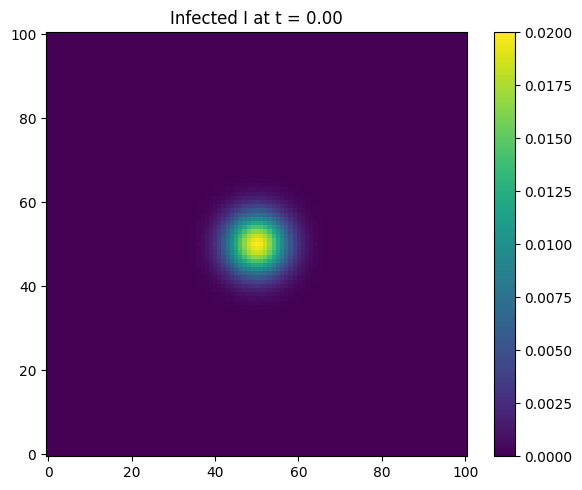

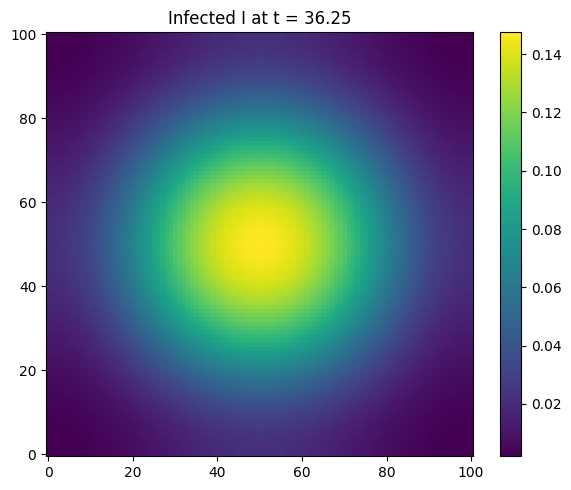

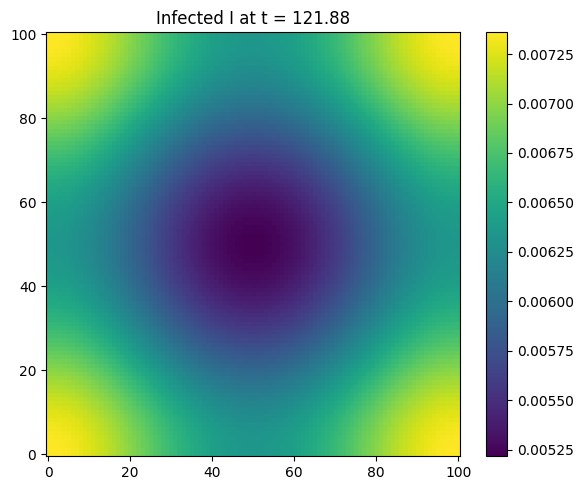

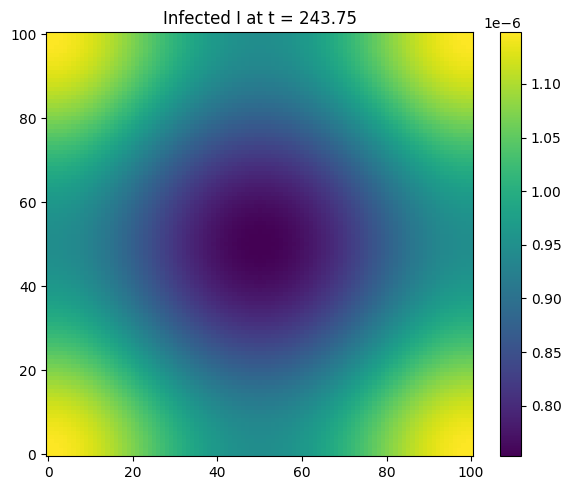

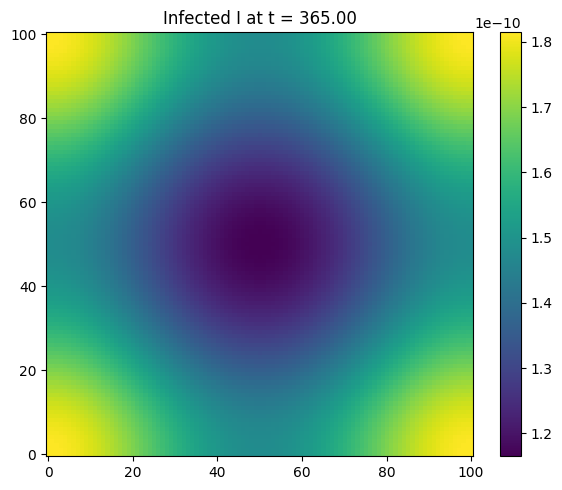

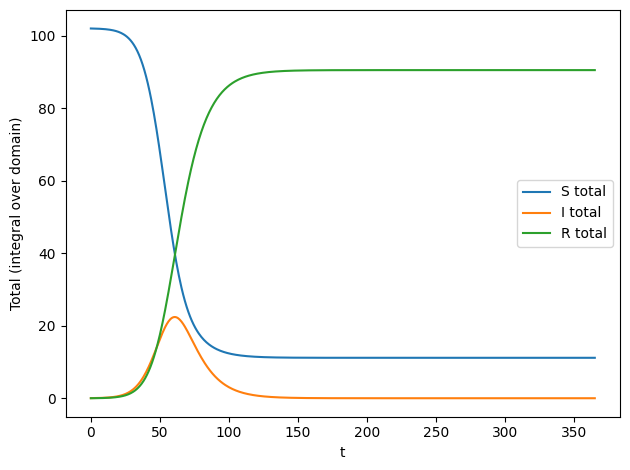

In [26]:
# pick a few snapshot indices
idxs = [0,len(times)//10, len(times)//3, 2*len(times)//3, len(times)-1]

for k in idxs:
    S_k, I_k, R_k = snapshots[k]
    plot_field(I_k, title=f"Infected I at t = {times[k]:.2f}")

def totals_over_time(times, snapshots, dx, dy):
    area = dx * dy
    S_tot = []
    I_tot = []
    R_tot = []
    for (S, I, R) in snapshots:
        S_tot.append(S.sum() * area)
        I_tot.append(I.sum() * area)
        R_tot.append(R.sum() * area)
    return np.array(S_tot), np.array(I_tot), np.array(R_tot)

S_tot, I_tot, R_tot = totals_over_time(times, snapshots, dx, dy)

plt.figure()
plt.plot(times, S_tot, label="S total")
plt.plot(times, I_tot, label="I total")
plt.plot(times, R_tot, label="R total")
plt.xlabel("t")
plt.ylabel("Total (integral over domain)")
plt.legend()
plt.tight_layout()

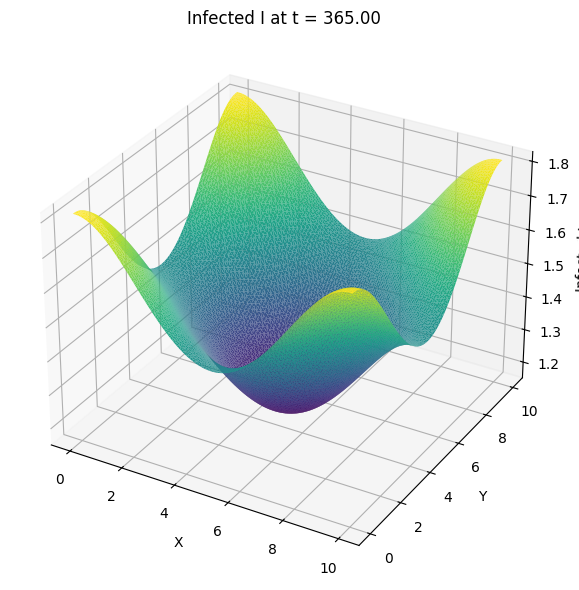

In [27]:
# Create 3d plot of infected population

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
X_flat = X.flatten()
Y_flat = Y.flatten()
I_k = snapshots[-1][1]
I_flat = I_k.flatten()
ax.plot_trisurf(X_flat, Y_flat, I_flat, cmap='viridis', edgecolor='none')
ax.set_title(f'Infected I at t = {times[-1]:.2f}')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Infected I')
plt.tight_layout()
plt.show()